<a href="https://colab.research.google.com/github/Dataniel31/telco-customer-churn-prediction/blob/main/alternativa2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#!wget https://raw.githubusercontent.com/Dataniel31/telco-customer-churn-prediction/main/train.csv
#!wget https://raw.githubusercontent.com/Dataniel31/telco-customer-churn-prediction/main/test.csv


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
# Cargar los datos
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.head()

,ID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5726,Female,0,No,No,5.0,Yes,No,Fiber optic,No,...,No,No,Yes,No,Month-to-month,No,Electronic check,80.20,384.25,No
1,5510,Female,1,No,No,3.0,Yes,No,Fiber optic,No,...,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,86.85,220.95,Yes
2,1272,Female,0,Yes,No,3.0,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Credit card (automatic),75.15,216.75,Yes
3,3577,Female,0,No,No,60.0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,Yes,One year,No,Credit card (automatic),80.55,4847.05,No
4,6546,Female,0,No,No,12.0,Yes,No,Fiber optic,Yes,...,No,Yes,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),98.90,1120.95,Yes


In [ ]:
# Imputar valores faltantes en 'tenure' con la mediana
train['tenure'].fillna(train['tenure'].median(), inplace=True)

# Imputar valores faltantes en las columnas de servicio con 'No'
service_columns = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
train[service_columns] = train[service_columns].fillna('No')

# Imputar valores faltantes en 'MonthlyCharges' y 'TotalCharges' con la mediana
train['MonthlyCharges'].fillna(train['MonthlyCharges'].median(), inplace=True)
train['TotalCharges'].fillna(train['TotalCharges'].median(), inplace=True)

# Verificar que no haya valores faltantes
print("\nTrain Data Missing Values After Imputation:")
print(train.isnull().sum())



Train Data Missing Values After Imputation:
ID                  0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

def encode_features(df):
    le = LabelEncoder()
    categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                             'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                             'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                             'PaperlessBilling', 'PaymentMethod']

    for feature in categorical_features:
        df[feature] = le.fit_transform(df[feature])

    return df

# Aplicar codificación a los conjuntos de entrenamiento y prueba
train = encode_features(train)
test = encode_features(test)

# Verificar la codificación
print("\nTrain Data After Encoding:")
print(train.head())



Train Data After Encoding:
     ID  gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0  5726       0              0        0           0     5.0             1   
1  5510       0              1        0           0     3.0             1   
2  1272       0              0        1           0     3.0             1   
3  3577       0              0        0           0    60.0             1   
4  6546       0              0        0           0    12.0             1   

   MultipleLines  InternetService  OnlineSecurity  ...  DeviceProtection  \
0              0                1               0  ...                 0   
1              0                1               0  ...                 2   
2              2                1               0  ...                 0   
3              2                0               0  ...                 2   
4              0                1               2  ...                 0   

   TechSupport  StreamingTV  StreamingMovies  Contra

In [ ]:
# Crear una nueva característica 'ChargePerMonth'
train['ChargePerMonth'] = train['TotalCharges'] / (train['tenure'] + 1)  # Añadir 1 para evitar división por cero
test['ChargePerMonth'] = test['TotalCharges'] / (test['tenure'] + 1)

# Verificar las nuevas características
print("\nTrain Data With New Features:")
print(train.head())



Train Data With New Features:
     ID  gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0  5726       0              0        0           0     5.0             1   
1  5510       0              1        0           0     3.0             1   
2  1272       0              0        1           0     3.0             1   
3  3577       0              0        0           0    60.0             1   
4  6546       0              0        0           0    12.0             1   

   MultipleLines  InternetService  OnlineSecurity  ...  TechSupport  \
0              0                1               0  ...            0   
1              0                1               0  ...            0   
2              2                1               0  ...            0   
3              2                0               0  ...            2   
4              0                1               2  ...            2   

   StreamingTV  StreamingMovies  Contract  PaperlessBilling  PaymentMethod  \
0

In [ ]:
from sklearn.model_selection import train_test_split

# Convertir 'Churn' a valores binarios
le = LabelEncoder()
train['Churn'] = le.fit_transform(train['Churn'])

# Separar características y objetivo
X = train.drop(columns=['Churn'])
y = train['Churn']

# Convertir variables categóricas a variables dummy
X = pd.get_dummies(X, drop_first=True)

# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")


Shape of X_train: (3944, 21)
Shape of X_val: (986, 21)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV

# Definir una función para evaluar modelos
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    print(model.__class__.__name__)
    print(classification_report(y_val, y_val_pred))
    print(f"F1 Score: {f1_score(y_val, y_val_pred)}")

# Modelos a evaluar
models = [
    LogisticRegression(max_iter=1000, random_state=42),
    RandomForestClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42)
]

# Evaluar cada modelo
for model in models:
    evaluate_model(model, X_train, y_train, X_val, y_val)


LogisticRegression
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       735
           1       0.67      0.57      0.62       251

    accuracy                           0.82       986
   macro avg       0.77      0.74      0.75       986
weighted avg       0.81      0.82      0.82       986

F1 Score: 0.6193548387096774
RandomForestClassifier
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       735
           1       0.66      0.51      0.58       251

    accuracy                           0.81       986
   macro avg       0.75      0.71      0.73       986
weighted avg       0.80      0.81      0.80       986

F1 Score: 0.5771812080536912
GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       735
           1       0.68      0.53      0.60       251

    accuracy                           0.82       986
 

In [ ]:
from sklearn.model_selection import GridSearchCV

# Definir los parámetros a probar
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularización
    'solver': ['liblinear', 'saga']  # Algoritmos de optimización
}

# Inicializar el modelo
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Configurar GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Ajustar GridSearchCV
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros y el mejor puntaje
print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

# Evaluar el modelo óptimo
best_log_reg = grid_search.best_estimator_
evaluate_model(best_log_reg, X_train, y_train, X_val, y_val)


Best parameters: {'C': 0.1, 'solver': 'liblinear'}
Best F1 score: 0.5856436984235439
LogisticRegression
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       735
           1       0.67      0.58      0.62       251

    accuracy                           0.82       986
   macro avg       0.77      0.74      0.75       986
weighted avg       0.81      0.82      0.82       986

F1 Score: 0.6209850107066381


In [ ]:
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Evaluar el modelo con datos balanceados
best_log_reg.fit(X_train_smote, y_train_smote)
y_val_pred_smote = best_log_reg.predict(X_val)
print("Classification report with SMOTE:")
print(classification_report(y_val, y_val_pred_smote))
print(f"F1 Score with SMOTE: {f1_score(y_val, y_val_pred_smote)}")


Classification report with SMOTE:
              precision    recall  f1-score   support

           0       0.90      0.76      0.83       735
           1       0.52      0.75      0.61       251

    accuracy                           0.76       986
   macro avg       0.71      0.76      0.72       986
weighted avg       0.80      0.76      0.77       986

F1 Score with SMOTE: 0.6146341463414634


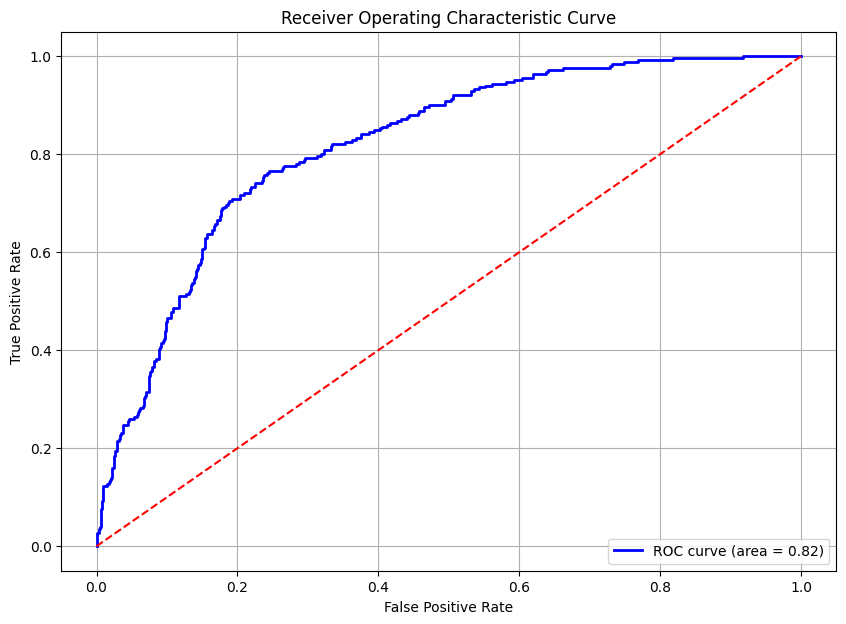

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Predecir probabilidades
y_val_prob = best_log_reg.predict_proba(X_val)[:, 1]

# Calcular ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
roc_auc = roc_auc_score(y_val, y_val_prob)

# Graficar ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
import joblib

# Guardar el modelo
joblib.dump(best_log_reg, 'best_logistic_regression_model.pkl')


['best_logistic_regression_model.pkl']

In [ ]:
from sklearn.model_selection import cross_val_score

# Evaluar el modelo con validación cruzada
cv_scores = cross_val_score(best_log_reg, X, y, cv=5, scoring='f1')
print(f"Mean F1 Score from Cross Validation: {cv_scores.mean()}")


Mean F1 Score from Cross Validation: 0.5963065921599982


In [ ]:
# Imputar valores faltantes en 'tenure' con la mediana
test['tenure'].fillna(train['tenure'].median(), inplace=True)

# Imputar valores faltantes en las columnas de servicio con 'No'
test[service_columns] = test[service_columns].fillna('No')

# Imputar valores faltantes en 'MonthlyCharges' y 'TotalCharges' con la mediana
test['MonthlyCharges'].fillna(train['MonthlyCharges'].median(), inplace=True)
test['TotalCharges'].fillna(train['TotalCharges'].median(), inplace=True)

# Crear la característica 'ChargePerMonth'
test['ChargePerMonth'] = test['TotalCharges'] / (test['tenure'] + 1)

# Codificar características
test = encode_features(test)

# Convertir variables categóricas a variables dummy
test = pd.get_dummies(test, drop_first=True)

# Asegurarse de que el conjunto de datos de prueba tiene las mismas columnas que el conjunto de entrenamiento
test = test.reindex(columns=X.columns, fill_value=0)

# Hacer predicciones
test_predictions = best_log_reg.predict(test)

# Convertir las predicciones a la forma deseada
test['Churn'] = le.inverse_transform(test_predictions)

# Crear el archivo de salida
submission = pd.DataFrame({
    'ID': test['ID'],
    'Churn': test['Churn']
})

submission.to_csv('submission.csv', index=False)
print("Archivo 'submission.csv' creado con éxito.")

Archivo 'submission.csv' creado con éxito.
